In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))


import importlib, numpy as np
from sys import path
import time

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection
from astropy import wcs

import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[27,15]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = "./"
emtk_path = base_path
path.append(emtk_path)

#sparse_multi_instrument_path = '/home/jplowman/research/solar_physics/projects/multi_instrument_dem_prototype/modules'
#path.append(sparse_multi_instrument_path)

#import EMToolKit
#importlib.reload(EMToolKit.visualization.dashboard)

import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_figure
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper

#jupyter nbextension enable --py widgetsnbextension

/home/jplowman/research/solar_physics/projects/EMToolKit/EMToolKit/schemas/util.py:37: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(fastmath=True, parallel=True)


In [2]:
import EMToolKit
import EMToolKit.visualization
importlib.reload(EMToolKit)
importlib.reload(EMToolKit.visualization)
importlib.reload(EMToolKit.visualization.dashboard)
import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_figure

In [4]:
xlen = 512*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 512*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -300*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -425*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

xlen = 400*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 400*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -0*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -0*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

sdo_data_dir = base_path+"data/20120711/" # Place to put data files. You'll need to change it or create these subdirectories
# Example data to load. We'll use a part of the field of view observed by the Hi-C rocket in 2012.
date='2012/07/11 18:54:00' 

# Commands for initial data download. Comment out once that's successful.
# VSO can sometimes be a bit flakey here, in my experience, may require multiple tries:
#paths = []
#passbands = np.array([94,131,171,193,211,335])*u.angstrom
#for band in passbands: 
#    qry = Fido.search(a.Time(TimeRange(date,12*u.s)),a.Instrument('AIA'),a.Wavelength(band))[0,0]
#    paths.append(Fido.fetch(qry,path=sdo_data_dir))

# Manually entered paths for after initial data download, may need to be edited.
paths = ['aia_lev1_131a_2012_07_11t18_54_08_62z_image_lev1.fits',  'aia_lev1_193a_2012_07_11t18_54_06_84z_image_lev1.fits',  'aia_lev1_335a_2012_07_11t18_54_02_62z_image_lev1.fits',
'aia_lev1_171a_2012_07_11t18_54_11_34z_image_lev1.fits',  'aia_lev1_211a_2012_07_11t18_54_11_62z_image_lev1.fits',  'aia_lev1_94a_2012_07_11t18_54_01_12z_image_lev1.fits']
for i in range(0,len(paths)): paths[i] = sdo_data_dir + paths[i]

In [5]:
maps = load_from_paths(paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
[maps,errs,trlogts,tresps] = aia_wrapper(maps)

[Text(0.5, 1.0, 'AIA 94 Temperature Response'),
 Text(0.5, 0, 'Temperature (dB Kelvin)'),
 Text(0, 0.5, 'Response (DN/s/(cm$^{-3})^2$/Mm)')]

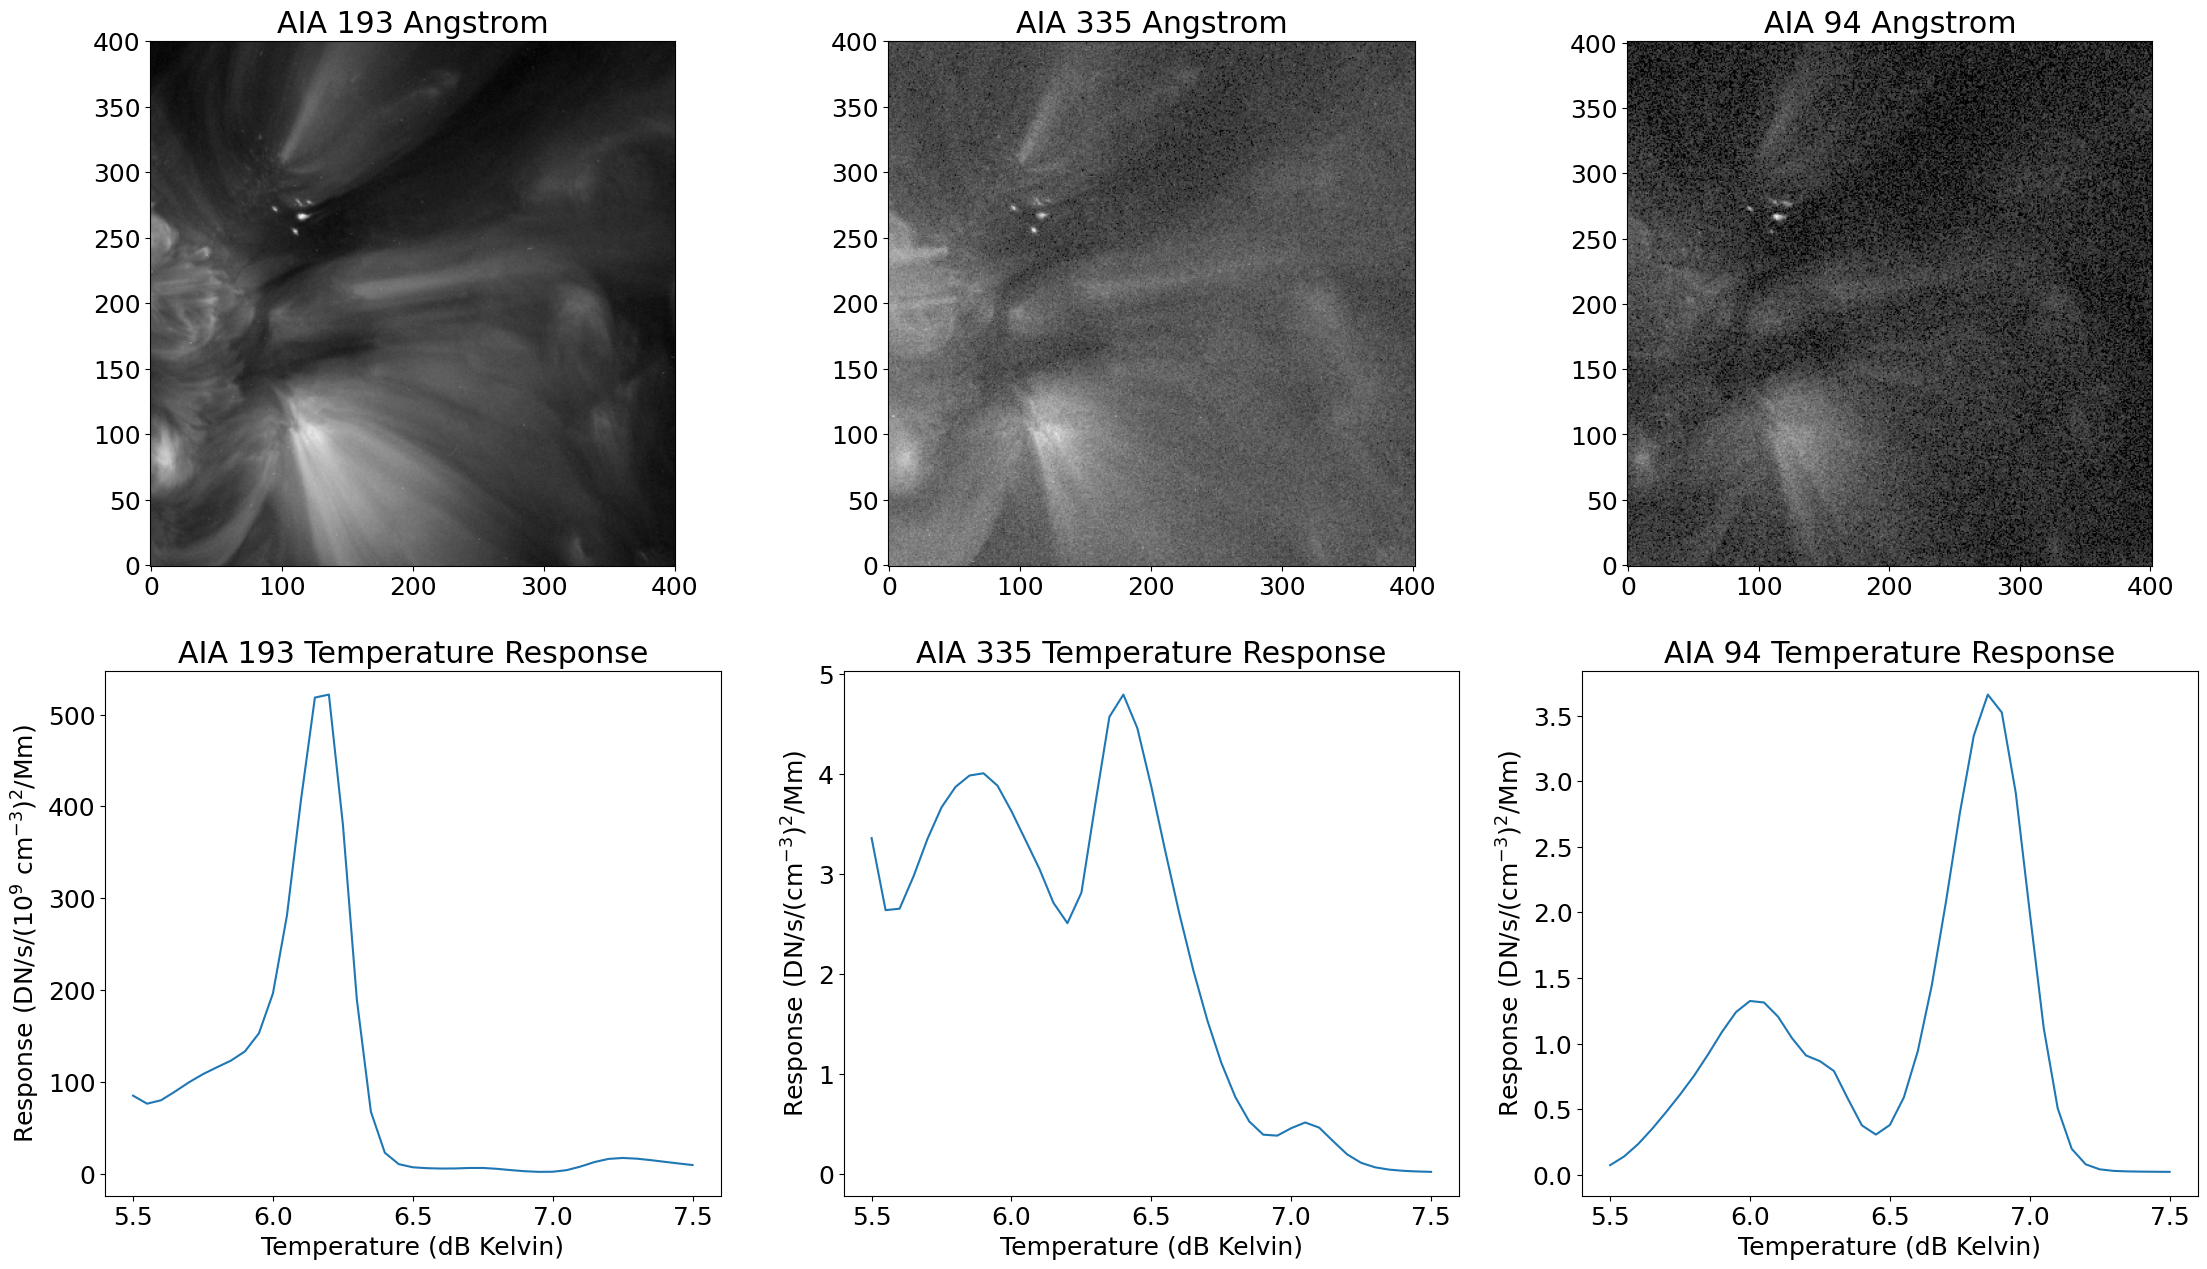

In [6]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,0].set(title='AIA 193 Angstrom')
axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,1].set(title='AIA 335 Angstrom')
axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,2].set(title='AIA 94 Angstrom')
axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
axs[1,2].set(title='AIA 94 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

In [7]:
# Make data sequence from AIA data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA data:
em_collection = emtk.em_collection(datasequence)

In [8]:
# Compute the DEM for Cheung et al. sparse EM method:
# Make DEM sequence from the DEM and add it to the collection:
if(('sparse_em_demsequence' in locals()) == False): 
    tstart=time.time()
    spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm = sparse_em_wrapper(datasequence)
    sparse_em_demsequence = emtk.dem_model(spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm, sparse_em_wrapper)
    print('Sparse method took',time.time()-tstart)
em_collection.add_model(sparse_em_demsequence)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Sparse method took 57579.15424966812


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


In [10]:
# Compute the DEM for Plowman & Caspi simple_reg_dem method:
# Make DEM sequence from the DEM and add it to the collection:
if(('simple_reg_demsequence' in locals()) == False): 
    tstart=time.time()
    simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm = simple_reg_dem_wrapper(datasequence)
    print('Simple method took',time.time()-tstart)
    simple_reg_demsequence = emtk.dem_model(simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm, simple_reg_dem_wrapper)
em_collection.add_model(simple_reg_demsequence)

Simple method took 67.24403834342957
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


In [11]:
spars_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=spars_algorithm)

In [12]:
simpl_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=simpl_algorithm)

In [13]:
def calc_resids(synthdata, em_collection):# Calculate the residuals and Chi squared:
    ndata = len(synthdata)
    resids = []
    datasequence = em_collection.data()
    chi2 = 0
    [nx,ny] = datasequence[0].data.shape
    for seq in datasequence: [nx,ny] = [np.min([seq.data.shape[0],nx]),np.min([seq.data.shape[1],ny])]
    for i in range(0,ndata):
        exptime = datasequence[i].meta['exptime']
        nx = np.min([synthdata[i].data.shape[0],datasequence[i].data.shape[0],datasequence[i].uncertainty.array.shape[0]])
        ny = np.min([synthdata[i].data.shape[1],datasequence[i].data.shape[1],datasequence[i].uncertainty.array.shape[1]])
        resids.append(((exptime*synthdata[i].data[0:nx,0:ny]-datasequence[i].data[0:nx,0:ny])/datasequence[i].uncertainty.array[0:nx,0:ny])**2)
        chi2 += np.mean(resids)/ndata        
    return resids, chi2

spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
print('simple_reg_dem Chi squared = ',simpl_chi2, 'spars_em Chi squared = ',spars_chi2)

simple_reg_dem Chi squared =  0.9382546279577649 spars_em Chi squared =  1.2839538742592504


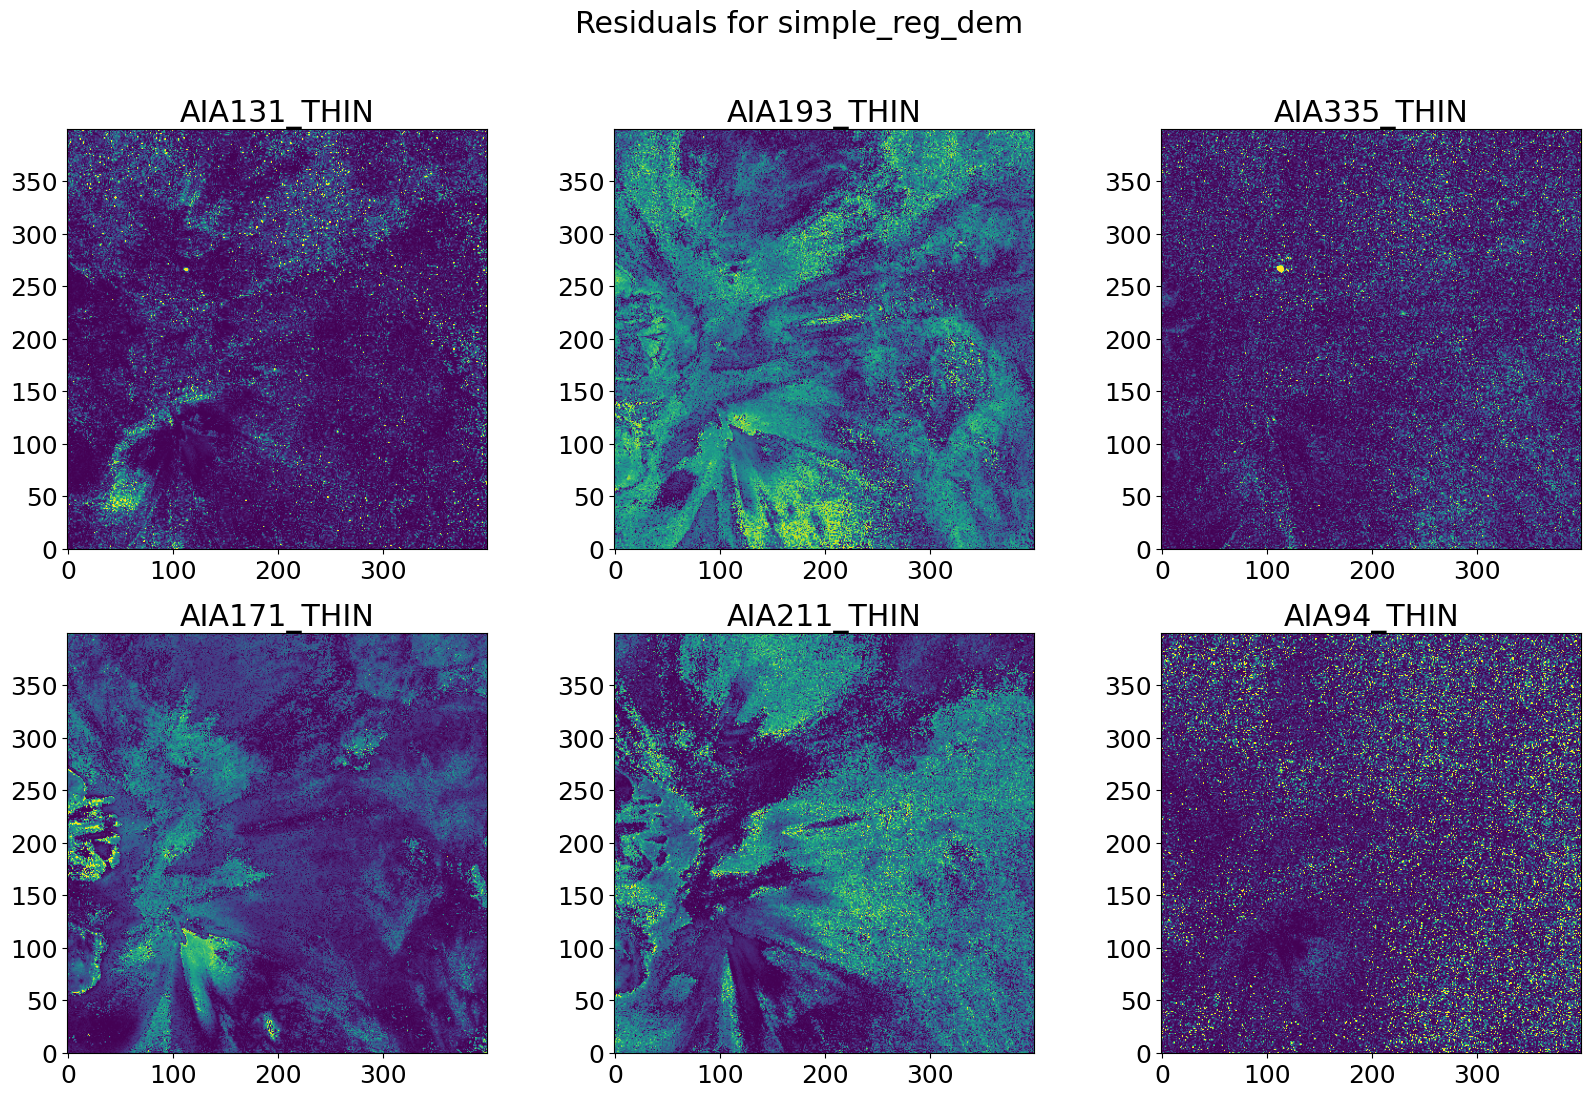

In [14]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+simpl_algorithm)
for i in range(0,6):
    ax1 = fig.add_subplot(2,3,i+1)
    ax1.imshow(simpl_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

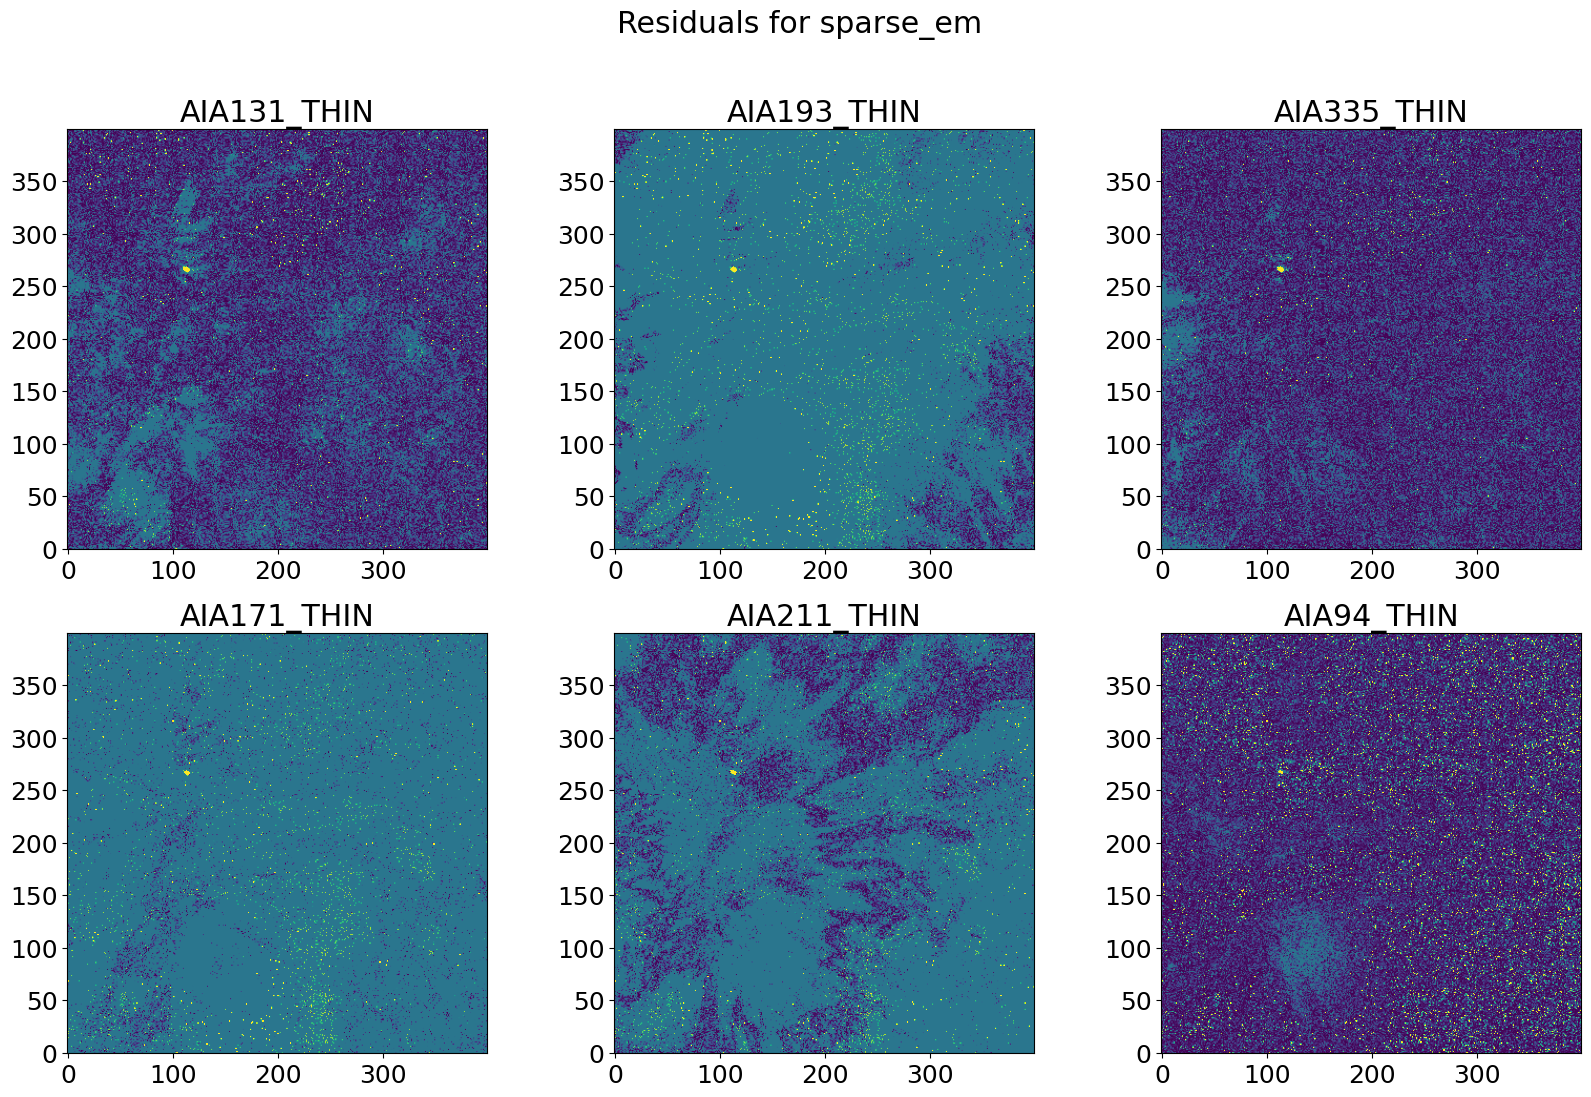

In [15]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+spars_algorithm)
for i in range(0,6):
    ax1 = fig.add_subplot(2,3,i+1)
    ax1.imshow(spars_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

In [16]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


class dashboard_object(object):
    def __init__(self,em_collection):
        self.emc = em_collection
        
    def widgwrap(self, xpt, ypt, rtemp, gtemp, btemp, sigma, algorithm):
        dashboard_figure(self.emc, plotpoint=[xpt,ypt], temperatures=[rtemp,gtemp,btemp], sigmas=sigma, algorithm=algorithm)

In [17]:
dash = dashboard_object(em_collection)

In [18]:
[nx,ny] = dash.emc.collection[dash.emc.collection['models'][0]][0].data.shape
xpt=widgets.IntSlider(min=0, max=nx, value=10, step=1, description='xpt', continuous_update=False) 
ypt=widgets.IntSlider(min=0, max=ny, value=100, step=1, description='ypt', continuous_update=False)
rtemp=widgets.FloatSlider(min=5, max=7, value=5.8, step=0.05, description='rtemp', continuous_update=False)
gtemp=widgets.FloatSlider(min=5, max=7, value=6.1, step=0.05, description='gtemp', continuous_update=False)
btemp=widgets.FloatSlider(min=5, max=7, value=6.4, step=0.05, description='btemp', continuous_update=False)
sigma=widgets.FloatSlider(min=0.025, max=0.5, value=0.125, step=0.01, description='sigma', continuous_update=False)
algorithm=widgets.Dropdown(options=dash.emc.collection['models'], description='algorithm', continuous_update=False)
ui = widgets.HBox([xpt,ypt,rtemp,gtemp,btemp,sigma,algorithm])
out = widgets.interactive_output(dash.widgwrap, {'xpt':xpt,'ypt':ypt,'rtemp':rtemp,'gtemp':gtemp,'btemp':btemp,'sigma':sigma,'algorithm':algorithm})
display(ui,out)

Output()